# ELE8812 - Analyse multirésolution
## Démo. 1: Analyse pyramidale
Joël Lefebvre, Hiver 2018

Pour une version interactive de ce notebook: [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/joe-from-mtl/ele8812_Cours_AnalyseMultiresolution/master?filepath=notebooks%2FDemo1_AnalysePyramidale.ipynb)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

from skimage.data import astronaut

# Option d'affichage
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Définition
_Pyramid, or pyramid representation, is a type of **multi-scale signal representation** developed by the computer vision, image processing and signal processing communities, in which a signal or an image is subject to **repeated smoothing and subsampling**. Pyramid representation is a predecessor to scale-space representation and multiresolution analysis._ 
([Wikipedia](https://en.wikipedia.org/wiki/Pyramid_(image_processing)) 

![Exemple de décomposition pyramidale](https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Image_pyramid.svg/300px-Image_pyramid.svg.png)

## Algorithme simple de décomposition APR

** Étapes de l'algorithme **
1. Calcul d'une approximation $j-1$ de l'image de niveau $j$
2. Prédiction de l'image de niveau $j$ d'après l'approximation $j$
3. Calcul des résidus d'approximation du niveau $j$
![Diagramme_Algorithme_Pyramide](../images/Diagramme_AnalysePyramidale.png "Titre de l'image")

In [5]:
# Image utilisée pour cette démonstration
help(astronaut)

Help on function astronaut in module skimage.data:

astronaut()
    Colour image of the astronaut Eileen Collins.
    
    Photograph of Eileen Collins, an American astronaut. She was selected
    as an astronaut in 1992 and first piloted the space shuttle STS-63 in
    1995. She retired in 2006 after spending a total of 38 days, 8 hours
    and 10 minutes in outer space.
    
    This image was downloaded from the NASA Great Images database
    <https://flic.kr/p/r9qvLn>`__.
    
    No known copyright restrictions, released into the public domain.
    
    Returns
    -------
    astronaut : (512, 512, 3) uint8 ndarray
        Astronaut image.



## Exemple de décomposition pyramidale

## Image originale

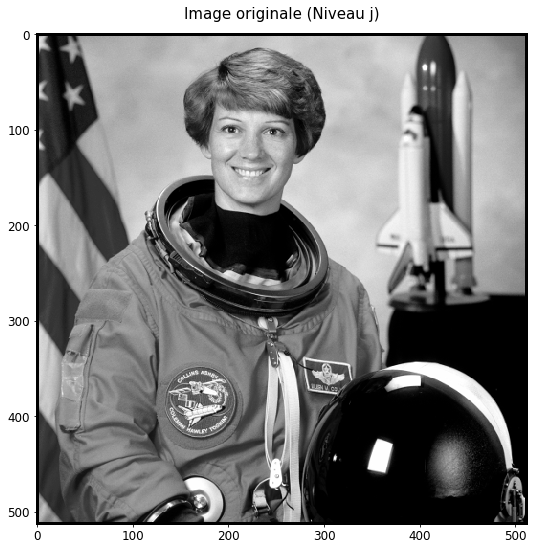

In [6]:
image = astronaut().mean(axis=2)
plt.imshow(image); 
plt.title('Image originale (Niveau j)')
plt.show()

## Approximation $j - 1$


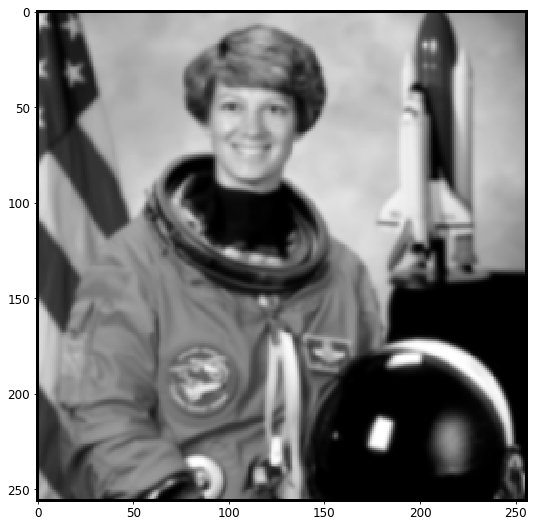

In [7]:
# Approximation (Filtre Gaussien 2D)
img_approx = gaussian_filter(image, sigma=2)

# Sous-échantillonnage d'un facteur 2
img_approx = img_approx[0::2, 0::2]

plt.imshow(img_approx); plt.show() 

## Prédiction et résidu du niveau $j$

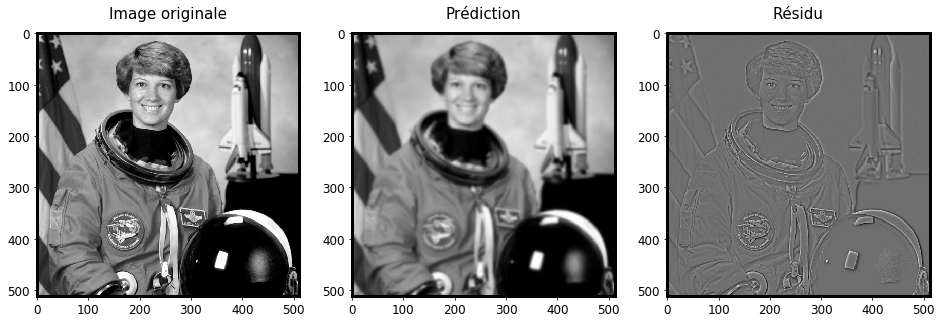

In [9]:
nx, ny = image.shape; nx_a, ny_a = img_approx.shape

x_0, y_0 = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,ny))
x_1, y_1 = np.meshgrid(np.linspace(0,1,nx_a), np.linspace(0,1,ny_a))
points = np.array([x_1.ravel(), y_1.ravel()]).T
values = img_approx.ravel()

# Interpolation bi-linéaire
img_prediction = griddata(points, values, (x_0, y_0), method='linear')

# Calcul du résidu pour le niveau j=1
img_residu = image - img_prediction

plt.subplot(131); plt.imshow(image); plt.title('Image originale')
plt.subplot(132); plt.imshow(img_prediction); plt.title(u'Prédiction')
plt.subplot(133); plt.imshow(img_residu); plt.title(u'Résidu')
plt.show()

## Décomposition pyramidale
* Répétition de l'algorithme d'approximation, prédiction et résidu.


In [10]:
def decomposition_apr(img, k=1):
    # Approximation (Filtre Gaussien 2D)
    img_approx = gaussian_filter(img, k)

    # Sous-échantillonnage d'un facteur 2
    img_approx = img_approx[0::2, 0::2]
    
    nx, ny = img.shape; nx_a, ny_a = img_approx.shape
    x_0, y_0 = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,ny))
    x_1, y_1 = np.meshgrid(np.linspace(0,1,nx_a), np.linspace(0,1,ny_a))
    points = np.array([x_1.ravel(), y_1.ravel()]).T
    values = img_approx.ravel()

    # Interpolation bi-linéaire
    img_prediction = griddata(points, values, (x_0, y_0), method='linear')

    # Calcul du résidu
    img_residu = img - img_prediction
    
    return img_approx, img_prediction, img_residu

In [11]:
def display_pyramid_iteration(img, img_approx, img_prediction, img_residual, j):
    plt.subplot(141); plt.imshow(img); plt.title('Image originale (j={})'.format(nombre_de_niveaux - j))
    plt.subplot(142); plt.imshow(img_approx); plt.title(u'Image approximée (j={})'.format(nombre_de_niveaux - j + 1))
    plt.subplot(143); plt.imshow(img_prediction); plt.title(u'Image prédite (j={})'.format(nombre_de_niveaux - j))
    plt.subplot(144); plt.imshow(img_residu); plt.title(u'Résidu (j={})'.format(nombre_de_niveaux - j))
    plt.show()

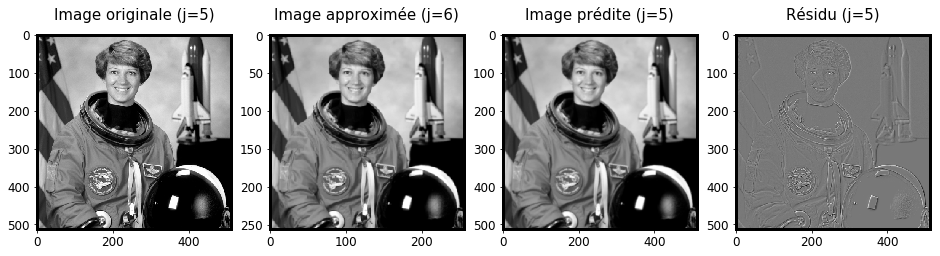

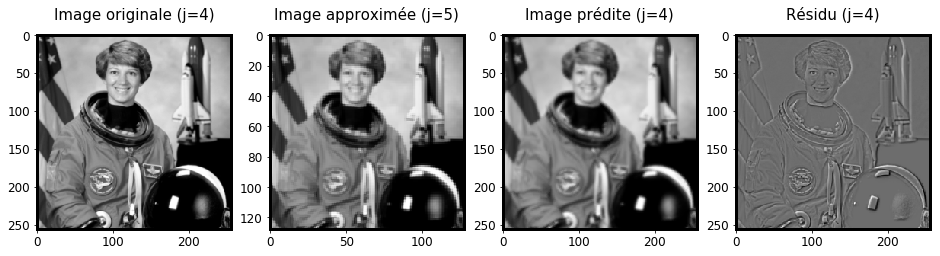

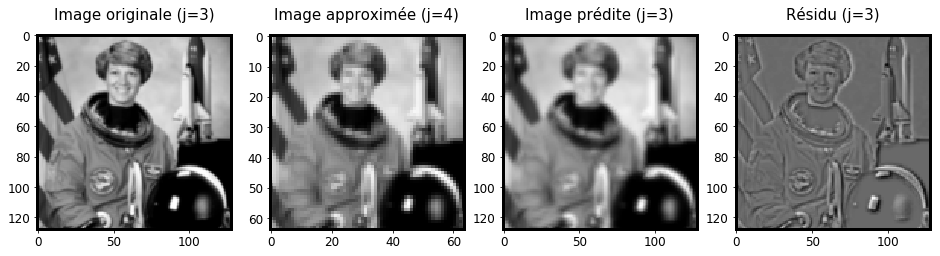

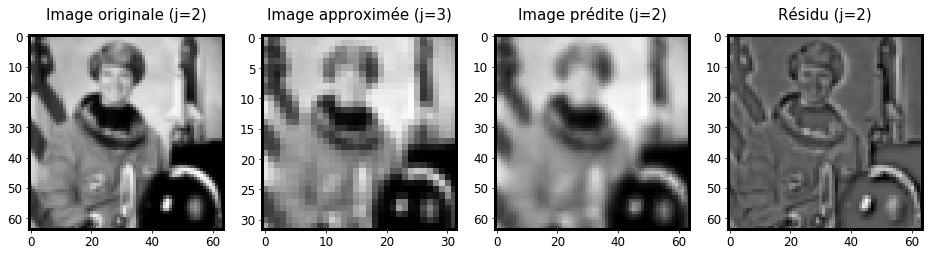

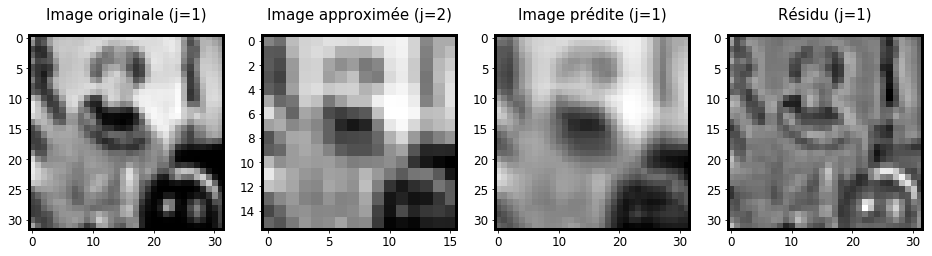

In [12]:
## Exemple de décomposition pyramidale à plusieurs niveaux
nombre_de_niveaux = 5
img_last = image
pyramid_gaussian = list()
pyramid_laplacian = list()
for j in range(nombre_de_niveaux):
    img_approx, img_prediction, img_residu = decomposition_apr(img_last)
    display_pyramid_iteration(img_last, img_approx, img_prediction, img_residu, j)
    
    # Ajout des approximations et résidus dans chaque pyramide
    pyramid_gaussian.append(img_last)
    pyramid_laplacian.append(img_residu)
    
    # Modification de la nouvelle image d'entrée
    img_last = img_approx
    
# Finalement, la dernière approximation est retenue pour chaque décomposition
pyramid_gaussian.append(img_approx)
pyramid_laplacian.append(img_approx)

In [13]:
def display_pyramid(pyramid):
    nLevels = len(pyramid)
    
    for i in range(nLevels):
        plt.subplot(1,nLevels,i+1); 
        plt.imshow(pyramid[i], aspect='equal')
        plt.axis('off')
        plt.title('Niveau j={}'.format(nLevels - i - 1))
         
    plt.show()

## Pyramide de Gauss
* Formée des approximations à chaque niveau
* Utilisée pour la synthèse de texture.

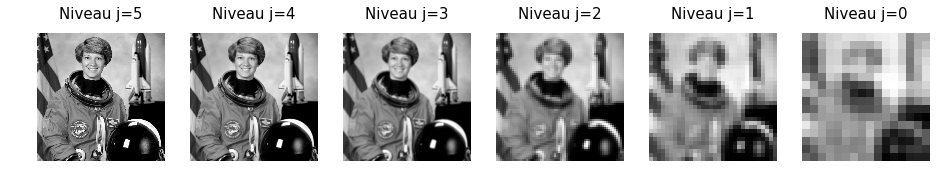

In [14]:
display_pyramid(pyramid_gaussian)

## Pyramide de Laplace
* Formée des résidus calculés à chaque niveau
* Le dernier niveau est l'approximation $j=0$
* Utilisée pour la compression d'image

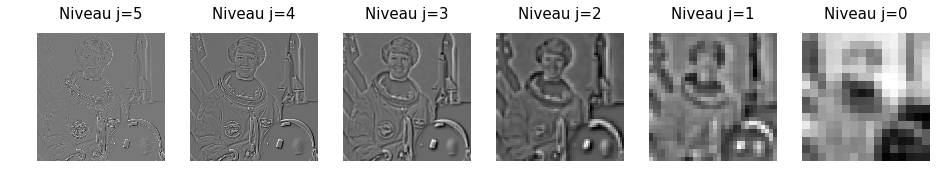

In [15]:
display_pyramid(pyramid_laplacian)

## Exemple de reconstruction pyramidale

In [16]:
def reconstruct_pyramid(pyramid, level):
    nLevels = len(pyramid)
    img_r = pyramid[-1]
    for i in range(1, level):
        img_next = pyramid[nLevels - i - 1]
        
        # Interpolation bilinéaire
        nx, ny = img_r.shape; nx_next, ny_next = img_next.shape
        x, y = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,ny))
        x_next, y_next = np.meshgrid(np.linspace(0,1,nx_next), np.linspace(0,1,ny_next))
        points = np.array([x.ravel(), y.ravel()]).T
        values = img_r.ravel()
        img_r_i = griddata(points, values, (x_next, y_next), method='linear')
        
        # Ajout du niveau j à la reconstruction
        img_r = img_r_i + img_next
        
    return img_r        

## Reconstruction de la pyramid de Gauss

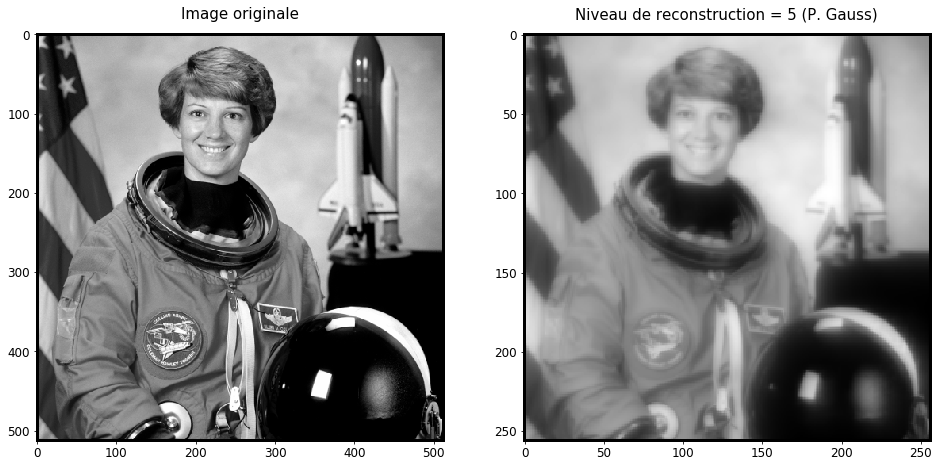

In [17]:
niveau = 5
img_r = reconstruct_pyramid(pyramid_gaussian, niveau)

plt.subplot(121); plt.imshow(image); plt.title('Image originale')
plt.subplot(122); plt.imshow(img_r); plt.title('Niveau de reconstruction = {} (P. Gauss)'.format(niveau)); 
plt.show()

## Reconstruction de la pyramid de Laplace

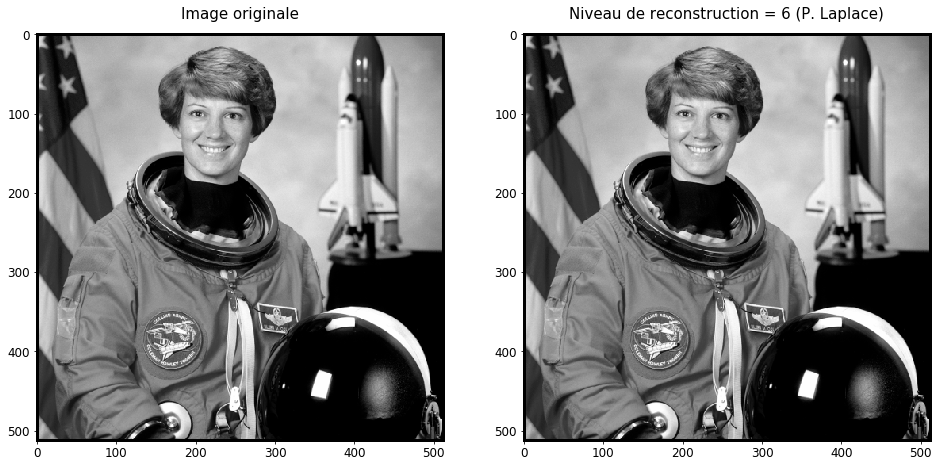

In [18]:
niveau = 6
img_r = reconstruct_pyramid(pyramid_laplacian, niveau)

plt.subplot(121); plt.imshow(image); plt.title('Image originale')
plt.subplot(122); plt.imshow(img_r); plt.title('Niveau de reconstruction = {} (P. Laplace)'.format(niveau)); 
plt.show()

## Erreur de reconstruction 
* Pyramide de Gauss: Perte des hautes fréquences à chaque échelle
* Pyramide de Laplace: Reconstruction sans perte (erreur numérique)

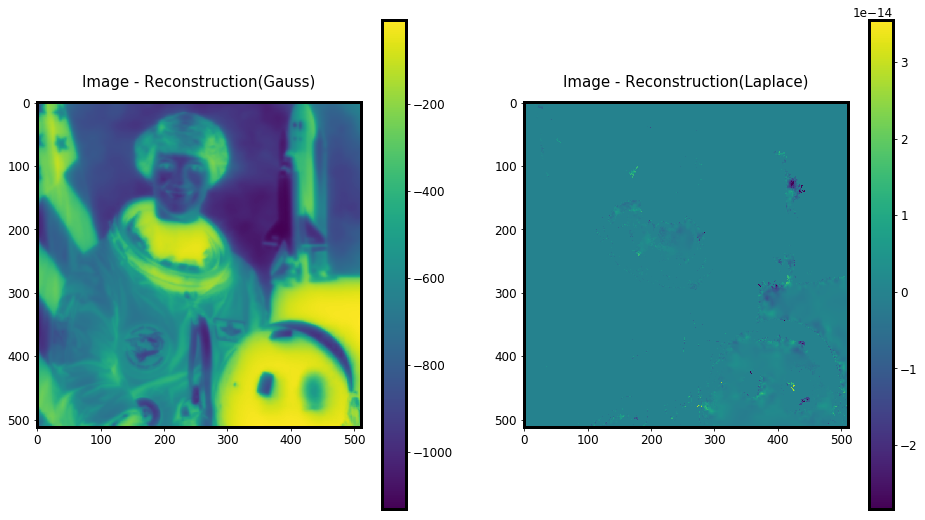

In [19]:
img_r_gauss = reconstruct_pyramid(pyramid_gaussian, len(pyramid_gaussian))
img_r_laplace = reconstruct_pyramid(pyramid_laplacian, len(pyramid_laplacian))

plt.subplot(121); plt.imshow(image - img_r_gauss, cmap='viridis'); plt.colorbar(); plt.title('Image - Reconstruction(Gauss)')
plt.subplot(122); plt.imshow(image - img_r_laplace, cmap='viridis'); plt.colorbar(); plt.title('Image - Reconstruction(Laplace)')
plt.show()  

# Exemples d'applications

* Compression d'image (Laplace)
* Fusion d'images (Laplace)
* Détection multi-échelles de contours (Gauss)
* Restauration d'image (Laplace)
* Rehaussement
* Champs de vue étendu


## Références
* Gonzalez, R.C. et Woods, R.E. "Digital iamge Processing", 3e édition, _Pearson, Prentice Hall_, (2008), 954p.
* https://en.wikipedia.org/wiki/Pyramid_(image_processing)
* Cours "ELE8812 - Traitement et analyse d'images" de Polytechnique Montréal. ([Lien](https://moodle.polymtl.ca/course/view.php?id=31))
* Notes du cours CSC 320 "Introduction to Visual Computing" @ UToronto. ([Lien](http://www.cs.toronto.edu/~jepson/csc320/notes/pyramids.pdf))